In [1]:
import os

# Get current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# Change working directory
new_directory = "E:\Python"
os.chdir(new_directory)

# Check if the directory has been changed
updated_directory = os.getcwd()
print("Updated working directory:", updated_directory)


Current working directory: C:\Users\LENOVO
Updated working directory: E:\Python


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




In [3]:
IMG_SIZE = (256, 256)
VALID_SPLIT = 0.3  # Validation split ratio
BATCH_SIZE = 32  # Batch size for training
SEED = 42  
PATH = "E:\Python\Downloads\Food Classification"

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Get validation image with generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 6269 files belonging to 20 classes.
Using 4389 files for training.
Found 6269 files belonging to 20 classes.
Using 1880 files for validation.


In [5]:
classes = train_ds.class_names

**************************************************************************************

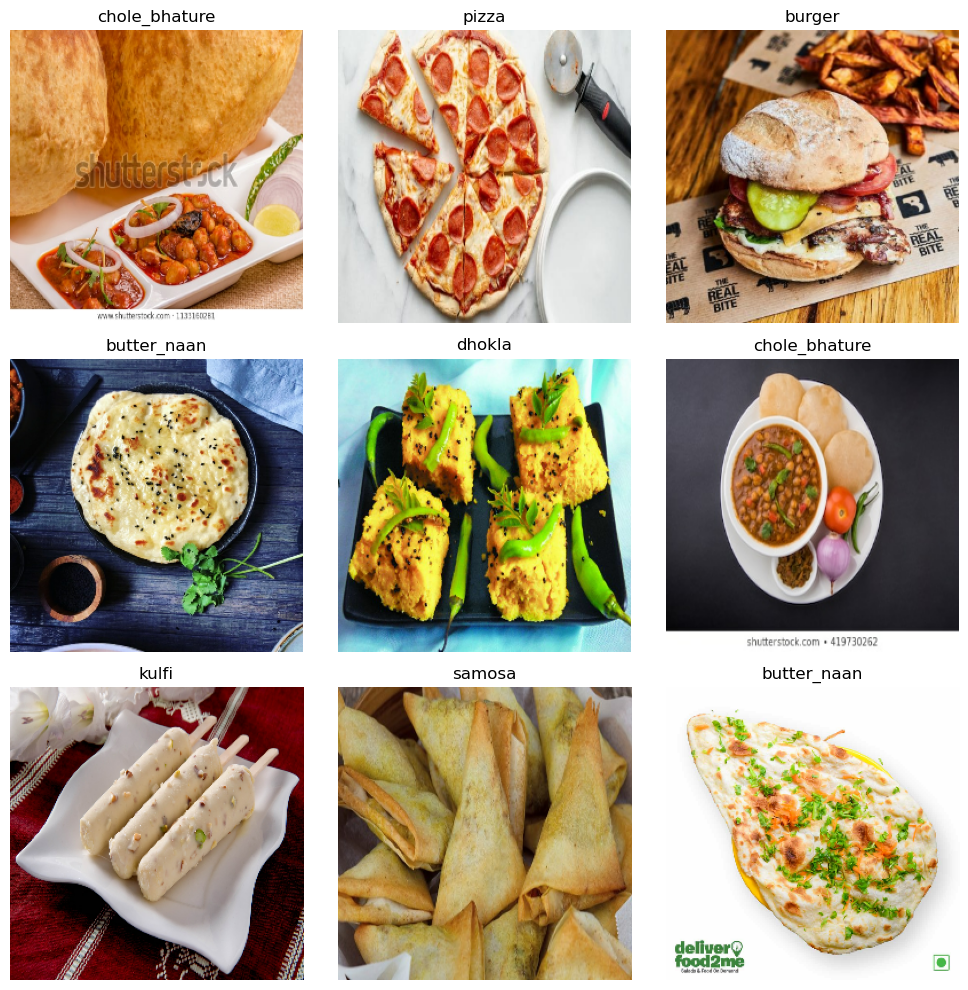

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, (images, labels) in enumerate(train_ds.take(9)):
    ax = axes[i//3, i%3]
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(classes[np.argmax(labels[i])])
    ax.axis("off")

plt.tight_layout()
plt.show()


In [7]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [8]:
def construct_model(input_shape, num_classes):
    # Define the input layer with the given shape
    inputs = keras.Input(shape=input_shape)
    
    # Apply the data augmentation to the inputs
    x = data_augmentation(inputs)

    # Rescale the pixel values from 0-255 to 0-1
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    
    # Define the entry block of the model
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Save the current state of the model
    previous_block_activation = x

    # Add several blocks to the model
    for size in [128, 256, 512, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project the residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add the residual back
        previous_block_activation = x  # Set aside the next residual

    # Add the final layers
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    # Return the constructed model
    return keras.Model(inputs, outputs)
print(IMG_SIZE + (3,))
model = construct_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))

(256, 256, 3)



In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['rescaling[0][0]']           
                                                                                              

In [10]:
ok=True

if ok:
    
    EPOCHS = 15
    CALLBACK = [
        keras.callbacks.ModelCheckpoint("filepath='model.{epoch:02d}-{val_loss:.2f}.h5'"),
        keras.callbacks.EarlyStopping(patience=15)
    ]
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    
    history = model.fit(
        augmented_train_ds,
        epochs=EPOCHS,
        callbacks=CALLBACK,
        validation_data=val_ds,
    )
else:
    model = keras.models.load_model("E:\Python\filepath='model.18-2.95.h5'")
    



Epoch 1/15


138/138 [==============================] - ETA: 0s - loss: 2.5991 - categorical_accuracy: 0.2151INFO:tensorflow:Assets written to: filepath='model.01-3.40.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.01-3.40.h5'\assets


138/138 [==============================] - 550s 4s/step - loss: 2.5991 - categorical_accuracy: 0.2151 - val_loss: 3.4016 - val_categorical_accuracy: 0.0670
Epoch 2/15
138/138 [==============================] - ETA: 0s - loss: 2.2582 - categorical_accuracy: 0.3080INFO:tensorflow:Assets written to: filepath='model.02-4.35.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.02-4.35.h5'\assets


138/138 [==============================] - 515s 4s/step - loss: 2.2582 - categorical_accuracy: 0.3080 - val_loss: 4.3450 - val_categorical_accuracy: 0.0670
Epoch 3/15
138/138 [==============================] - ETA: 0s - loss: 2.0360 - categorical_accuracy: 0.3746INFO:tensorflow:Assets written to: filepath='model.03-4.57.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.03-4.57.h5'\assets


138/138 [==============================] - 742s 5s/step - loss: 2.0360 - categorical_accuracy: 0.3746 - val_loss: 4.5675 - val_categorical_accuracy: 0.0670
Epoch 4/15
138/138 [==============================] - ETA: 0s - loss: 1.8567 - categorical_accuracy: 0.4295INFO:tensorflow:Assets written to: filepath='model.04-4.09.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.04-4.09.h5'\assets


138/138 [==============================] - 528s 4s/step - loss: 1.8567 - categorical_accuracy: 0.4295 - val_loss: 4.0935 - val_categorical_accuracy: 0.1154
Epoch 5/15
138/138 [==============================] - ETA: 0s - loss: 1.7098 - categorical_accuracy: 0.4780INFO:tensorflow:Assets written to: filepath='model.05-2.67.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.05-2.67.h5'\assets


138/138 [==============================] - 764s 6s/step - loss: 1.7098 - categorical_accuracy: 0.4780 - val_loss: 2.6746 - val_categorical_accuracy: 0.2957
Epoch 6/15
138/138 [==============================] - ETA: 0s - loss: 1.5696 - categorical_accuracy: 0.5174INFO:tensorflow:Assets written to: filepath='model.06-2.48.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.06-2.48.h5'\assets


138/138 [==============================] - 709s 5s/step - loss: 1.5696 - categorical_accuracy: 0.5174 - val_loss: 2.4845 - val_categorical_accuracy: 0.3431
Epoch 7/15
138/138 [==============================] - ETA: 0s - loss: 1.4343 - categorical_accuracy: 0.5621INFO:tensorflow:Assets written to: filepath='model.07-1.87.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.07-1.87.h5'\assets


138/138 [==============================] - 493s 4s/step - loss: 1.4343 - categorical_accuracy: 0.5621 - val_loss: 1.8658 - val_categorical_accuracy: 0.4601
Epoch 8/15
138/138 [==============================] - ETA: 0s - loss: 1.3824 - categorical_accuracy: 0.5769INFO:tensorflow:Assets written to: filepath='model.08-3.20.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.08-3.20.h5'\assets


138/138 [==============================] - 705s 5s/step - loss: 1.3824 - categorical_accuracy: 0.5769 - val_loss: 3.1989 - val_categorical_accuracy: 0.2835
Epoch 9/15
138/138 [==============================] - ETA: 0s - loss: 1.3296 - categorical_accuracy: 0.5935INFO:tensorflow:Assets written to: filepath='model.09-1.81.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.09-1.81.h5'\assets


138/138 [==============================] - 489s 4s/step - loss: 1.3296 - categorical_accuracy: 0.5935 - val_loss: 1.8060 - val_categorical_accuracy: 0.4739
Epoch 10/15
138/138 [==============================] - ETA: 0s - loss: 1.2386 - categorical_accuracy: 0.6177INFO:tensorflow:Assets written to: filepath='model.10-2.26.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.10-2.26.h5'\assets


138/138 [==============================] - 722s 5s/step - loss: 1.2386 - categorical_accuracy: 0.6177 - val_loss: 2.2552 - val_categorical_accuracy: 0.3846
Epoch 11/15
138/138 [==============================] - ETA: 0s - loss: 1.1385 - categorical_accuracy: 0.6573INFO:tensorflow:Assets written to: filepath='model.11-2.49.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.11-2.49.h5'\assets


138/138 [==============================] - 483s 3s/step - loss: 1.1385 - categorical_accuracy: 0.6573 - val_loss: 2.4903 - val_categorical_accuracy: 0.3707
Epoch 12/15
138/138 [==============================] - ETA: 0s - loss: 1.0749 - categorical_accuracy: 0.6705INFO:tensorflow:Assets written to: filepath='model.12-2.58.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.12-2.58.h5'\assets


138/138 [==============================] - 703s 5s/step - loss: 1.0749 - categorical_accuracy: 0.6705 - val_loss: 2.5793 - val_categorical_accuracy: 0.3330
Epoch 13/15
138/138 [==============================] - ETA: 0s - loss: 1.0294 - categorical_accuracy: 0.6885INFO:tensorflow:Assets written to: filepath='model.13-2.19.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.13-2.19.h5'\assets


138/138 [==============================] - 488s 4s/step - loss: 1.0294 - categorical_accuracy: 0.6885 - val_loss: 2.1908 - val_categorical_accuracy: 0.4665
Epoch 14/15
138/138 [==============================] - ETA: 0s - loss: 0.9492 - categorical_accuracy: 0.7081INFO:tensorflow:Assets written to: filepath='model.14-2.88.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.14-2.88.h5'\assets


138/138 [==============================] - 811s 6s/step - loss: 0.9492 - categorical_accuracy: 0.7081 - val_loss: 2.8835 - val_categorical_accuracy: 0.3824
Epoch 15/15
138/138 [==============================] - ETA: 0s - loss: 0.9389 - categorical_accuracy: 0.7143INFO:tensorflow:Assets written to: filepath='model.15-2.28.h5'\assets


INFO:tensorflow:Assets written to: filepath='model.15-2.28.h5'\assets


138/138 [==============================] - 484s 3s/step - loss: 0.9389 - categorical_accuracy: 0.7143 - val_loss: 2.2832 - val_categorical_accuracy: 0.4851


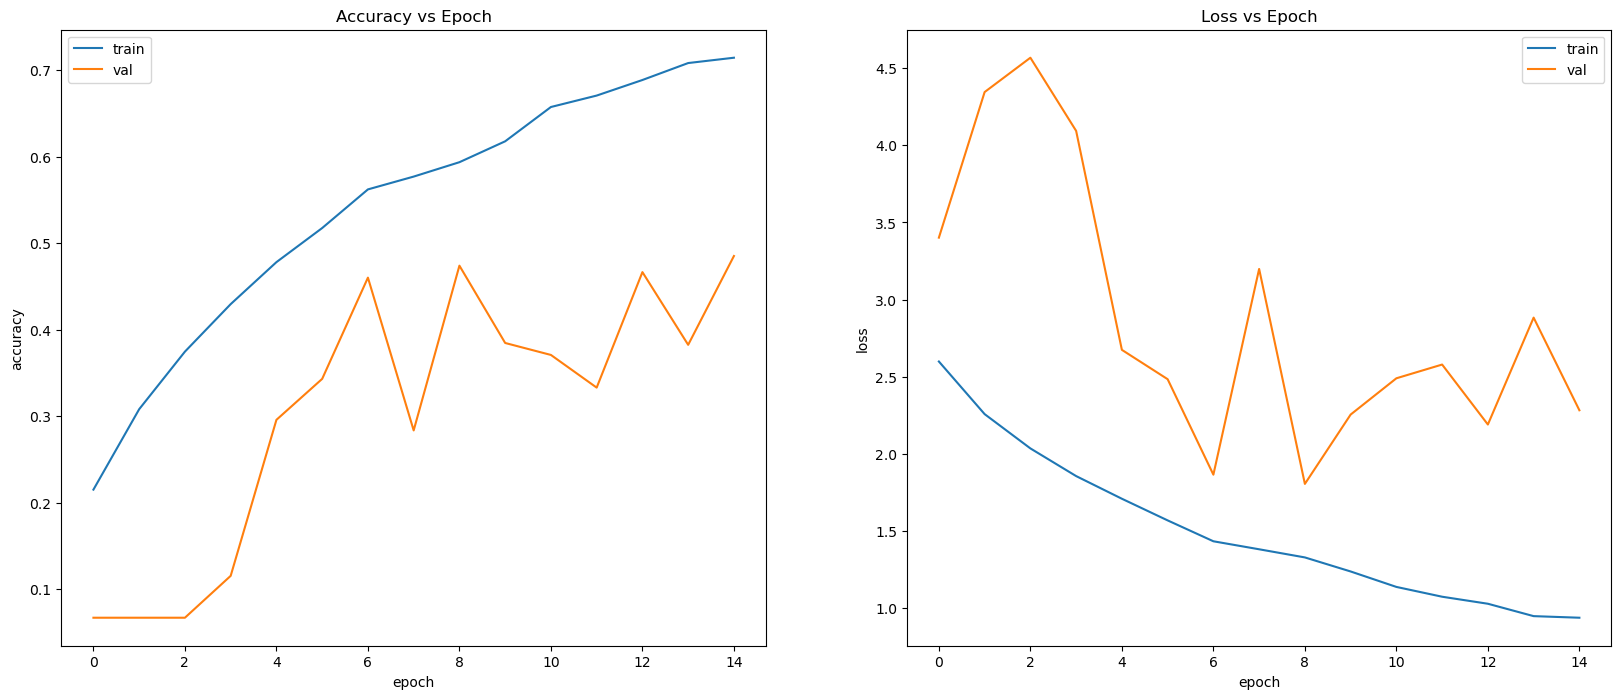

In [11]:
import seaborn as sns

# Create a figure and axes
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Summarize history for accuracy
sns.lineplot(x=range(len(history.history['categorical_accuracy'])), y=history.history['categorical_accuracy'], ax=ax[0], label='train')
sns.lineplot(x=range(len(history.history['val_categorical_accuracy'])), y=history.history['val_categorical_accuracy'], ax=ax[0], label='val')
ax[0].set_title('Accuracy vs Epoch')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')

# Summarize history for loss
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], ax=ax[1], label='train')
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], ax=ax[1], label='val')
ax[1].set_title('Loss vs Epoch')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')

# Display plots
plt.show()
